# Stock Price Prediction

In trading, valuable information is to know how the stock price will vary shortly. Here we are just interested in knowing if we have to buy stock or not. Supposing we get the information on the stock price evolution of the next day, if the price will increase, we'll buy stock, allowing us to make money. Otherwise, we will not purchase any stock to avoid losing money. We will build a Machine Learning model to predict if the stock price will increase the following day or not.

According to the goal set above, we want to maximize our `true positives` (cases where the model predicts that the price will go up and it acutally goes up). Therefore, we will use precision as our performance measure, which is `true positives / (false positives + true positives)`.

For this study case, we are going to build a model to predict the trend of the Microsoft stock price.

## Method

The realization of this project will be done through the following steps:


*   Downloading historical stock price from Yahoo finance
*   Data exploration
*   Data preprocessing
*   Test Machine Learning models
*   Setup a backtesting engine
*   Improve the accuracy of the model

At the end, we will add some perspectives to improve the model, and make it reliable for a real world use.



## Import useful librairies

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

## Downloading historical stock price from Yahoo finance

We first need to install the `Yahoo finance` package that we will use to get the stock price data.

In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 996 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
import yfinance as yf

#download microsoft stock price data
msft = yf.Ticker("MSFT")
msft = msft.history(period="max")

The execution of the previous code results in fetching the requested data and storing it in `msft` as a pandas dataframe. 

## Data exploration

In this section we are going to explore the collected data to understand how it looks like and what information is available.

In [5]:
#size of the data
msft.shape

(9209, 7)

In [6]:
msft.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055536,0.063703,0.055536,0.060980,1031788800,0.0,0.0
1986-03-14,0.060980,0.064247,0.060980,0.063158,308160000,0.0,0.0
1986-03-17,0.063158,0.064792,0.063158,0.064247,133171200,0.0,0.0
1986-03-18,0.064247,0.064792,0.062069,0.062613,67766400,0.0,0.0
1986-03-19,0.062613,0.063158,0.060980,0.061524,47894400,0.0,0.0


In [7]:
msft.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-09-19,242.470001,245.139999,240.850006,244.520004,26826900,0.0,0.0
2022-09-20,242.070007,243.509995,239.639999,242.449997,26660300,0.0,0.0
2022-09-21,244.270004,247.660004,238.899994,238.949997,28625600,0.0,0.0
2022-09-22,237.869995,243.860001,237.570007,240.979996,31061200,0.0,0.0
2022-09-23,239.539993,241.130005,235.199997,237.919998,34137200,0.0,0.0


We can see that we have of data for each day that Microsoft stock was traded. Here are the columns:


*   Open: the price the stock opened at the given day
*   High: the highest price during the day
*   Low: the lowest price during the day
*   Close: the closing price on the trading day
*   Volume: how many shares were traded

Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.

To see how the stock price has changed over time, we are going to plot the closing prices over the time.

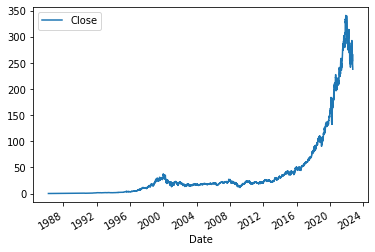

In [8]:
msft.plot.line(y="Close", use_index=True)

## Data preprocessing

The goal of this step is to prepare data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on the data from today. For that we need to identify our target and our predictors.

Our target will be if the price will go up or down tomorrow. If the price went up, the target will be `1` and if it went down, the target will be `0`. Since we want to use the data from the day before to predict the trend of the stock price the next day, we have to shift the data from previous days foward on day, so we can use it to predict the actual trend. This ensures that we don't use the data frome the same day to make predictions.

To build our training data, we will first ensure we know the actual closing price.

In [9]:
data = msft[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

We then have to setup our target.

In [10]:
data["Target"] = msft.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

Check if the classes are balanced, since it is a useful information for classification task.

In [11]:
data["Target"].value_counts()

1.0    4650
0.0    4558
Name: Target, dtype: int64

We notice that the two classes are balanced.

In [12]:
data.head(5)

,Actual_Close,Target
Date,,
1986-03-13,0.060980,NaN
1986-03-14,0.063158,1.0
1986-03-17,0.064247,1.0
1986-03-18,0.062613,0.0
1986-03-19,0.061524,0.0


Since we don't want to predict the current day using the same data, we need to shift our data

In [13]:
msft_prev = msft.copy()

In [14]:
msft_prev = msft_prev.shift(1)

In [15]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055536,0.063703,0.055536,0.060980,1.031789e+09,0.0,0.0
1986-03-17,0.060980,0.064247,0.060980,0.063158,3.081600e+08,0.0,0.0
1986-03-18,0.063158,0.064792,0.063158,0.064247,1.331712e+08,0.0,0.0
1986-03-19,0.064247,0.064792,0.062069,0.062613,6.776640e+07,0.0,0.0


Define the predictors we will use in predictions and add the corresponding data in our training data.

In [16]:
predictors = ["Close", "High", "Low", "Open", "Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [17]:
data.shape

(9208, 7)

In [18]:
data.head()

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
1986-03-14,0.063158,1.0,0.060980,0.063703,0.055536,0.055536,1.031789e+09
1986-03-17,0.064247,1.0,0.063158,0.064247,0.060980,0.060980,3.081600e+08
1986-03-18,0.062613,0.0,0.064247,0.064792,0.063158,0.063158,1.331712e+08
1986-03-19,0.061524,0.0,0.062613,0.064792,0.062069,0.064247,6.776640e+07
1986-03-20,0.059891,0.0,0.061524,0.063158,0.060980,0.062613,4.789440e+07


## Build the Machine Learning model

Now we are going to create a Machine Learning model to see how accurately we can predict the stock price trend.

Since we are dealing with time series data, we can't just use cross-validation logic in our training process. This will result in using future data to make predictions on the past prices, What will lead to a model well performing during the training, but unusable in the real world on new data.

Instead, we'll spleat the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

As the baseline model we'll use a random forest classifier. It is a good 'default' model, since it can pick up nonlinear relationships in the data, and somewhat robust to overfitting.

In [19]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

We will now check the accuracy of the model using the `precision` to measure the error. We will do this by using the `precision_score` function from scikit-learn.

In [20]:
preds = model.predict(test[predictors])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])

In [21]:
preds = pd.Series(preds, index=test.index)

In [23]:
precision_score(test["Target"], preds)

0.4606741573033708

We notice that our model actually has a precision of `46.06%`. We can take a deeper look at the individual predictions and the actuals, to see where the model is off.

In [24]:
combined = pd.concat({"Target": test["Target"], "Predictions":preds}, axis=1)

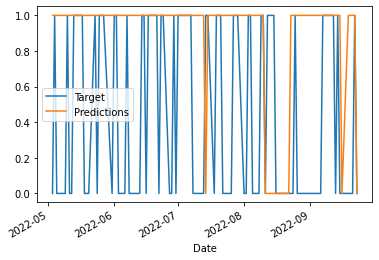

In [26]:
combined.plot()

Check the order of classes in predict_proba().

In [27]:
model.classes_

array([0., 1.])

### Back testing

Actually we are assessing the model performance only on the 100 last data points, what is surely the best way of measuring the error of the model. To enhance the way of doing it, we will implement a back testing logic. Back testinng ensures that we only use data from before day that we're predicting. 

In the backtesting function we will:


*   Split the training and test data
*   Train a model
*   Make predictions on the test data using `predict_proba`. This is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is `0.5`, but we can set it to different value to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.



In [28]:
def backtest(data, model, predictors, START=1000, STEP = 750):
  predictions = []

  for i in range(START, data.shape[0], STEP):
    train = data.iloc[:i]
    test = data.iloc[i:(i+STEP)]  
    
    model.fit(train[predictors], train["Target"])

    preds = model.predict_proba(test[predictors])[:, 1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds <= .6] = 0

    combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
    predictions.append(combined)

  predictions = pd.concat(predictions)
  return predictions

In [29]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
predictions = backtest(data, model, predictors)
predictions.value_counts()

Target  Predictions
1.0     0.0            3810
0.0     0.0            3711
1.0     1.0             345
0.0     1.0             342
dtype: int64

In [30]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5021834061135371

## Improving the accuracy of the model

Actually, the model isn't very accurate. For this model to be useful, we have to get it to predict more accurately.

We will try to add some moremmmm predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [31]:
weekly_mean = data.rolling(7).mean()
quaterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()


weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [32]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quaterly_mean"] = quaterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quaterly_mean"] = data["annual_mean"] / data["quaterly_mean"]

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [33]:
full_predictors = predictors + ["weekly_mean", "quaterly_mean", "annual_mean", "annual_weekly_mean", "annual_quaterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

In [34]:
predictions = backtest(data.iloc[365:], model, full_predictors)
predictions.value_counts()

Target  Predictions
1.0     0.0            3756
0.0     0.0            3743
1.0     1.0             207
0.0     1.0             137
dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6017441860465116

Show how many trades we would make.

In [37]:
predictions.value_counts()

Target  Predictions
1.0     0.0            3756
0.0     0.0            3743
1.0     1.0             207
0.0     1.0             137
dtype: int64

Look at the individual prediction and the actual.

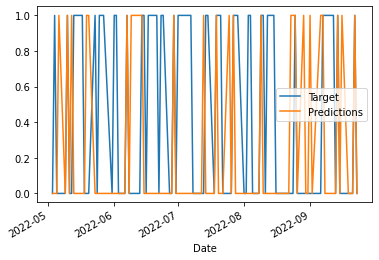

In [38]:
predictions.iloc[-100:].plot()

## Perspectives of improvement

+ Improve the technique

  * Calculate how much money you'd make if you traded with this algorithm

+ Improve the algorithm

  * Run with a reduced step size! This will take longer, but increase accuracy
  *Try discarding older data (only keeping data in a certain window)
  * Try a different machine learning algorithm
  * Tweak random forest parameters, or the prediction threshold

+ Add in more predictors

  * Account for activity post-close and pre-open

    + Early trading
    + Trading on other exchanges that open before the NYSE (to see what the global sentiment is)

  * Economic indicators
  
    + Interest rates
    + Other important economic news

  * Key dates

    + Dividends
    + External factors like elections

  * Company milestones

    + Earnings calls
    + Analyst ratings
    + Major announcements

  * Prices of related stocks

    + Other companies in the same sector
    + Key partners, customers, etc.